In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Vamos a ver las diferentes formas de calcular el omega bar

In [3]:
import numpy as np
# cm = np.loadtxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/new_phi_time.dat')
cm = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/new_phi_time.dat')
time_ = cm[:,1]
phi  = cm[:,2]

delta_t   = np.diff(time_[::-1])
delta_phi = np.diff(phi[::-1])

tt = time_[::-1][:-1]+delta_t/2.

veloc_ang = delta_phi/delta_t

In [4]:
1e9/3.086e16/3.17098e-8


1.0219051207939474

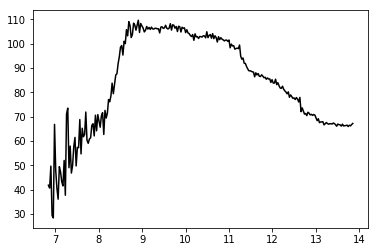

In [7]:
import matplotlib.pyplot as plt
plt.plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')

In [7]:
vv = veloc_ang*2*np.pi/360.*1.0219051207939474
print vv[-1]

67.20898078845921


In [17]:
data = np.loadtxt('../_data/correcciones/lbar_time_GD_new.dat')
# time_M31gd  = data[:,0]
lbar1_M31gd = data[:,1]
lbar3_M31gd = data[:,3]
lbar4_M31gd = data[:,4]
lbar5_M31gd = data[:,5]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_001_new.dat')
# time_M31gs  = data[:,0]
lbar1_M31gs = data[:,1]
lbar3_M31gs = data[:,3]
lbar4_M31gs = data[:,4]
lbar5_M31gs = data[:,5]

data = np.loadtxt('../_data/correcciones/lbar_time_GS_002_new.dat')
# time_MWgs  = data[:,0]
lbar1_MWgs = data[:,1]
lbar3_MWgs = data[:,3]
lbar4_MWgs = data[:,4]
lbar5_MWgs = data[:,5]

## Omega bar vs time GADGET

In [13]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
import tenform as ten
import elipsoide2 as elip


#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

# path0 = '/home/omarioni/'
path0 = '/home/ornela/SimCLUES/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

# path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
path2 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'


# path = '/mnt/is2/alejandro/ornella/'
path = '/home/ornela/SimCLUES/'
snapshot=range(496,300,-1)
k = 0
for isnap in snapshot:
    
    snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
#     halos = (0,1,3)
    # for i in halos:
    j = 0
    cm   = snap['subhalo_'+ str('%03d' %j) + '/Center'][()]
    r200 = snap['subhalo_'+ str('%03d' %j) + '/R200'][()]

    pstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Coordinates'][()]
    IDs  = snap['subhalo_'+ str('%03d' %j) + '/Str/Ids'][()]
    mstr = snap['subhalo_'+ str('%03d' %j) + '/Str/Masses'][()]
    vel  = snap['subhalo_'+ str('%03d' %j) + '/Str/Velocities'][()]

    pgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Coordinates'][()]
    mgas = snap['subhalo_'+ str('%03d' %j) + '/Gas/Masses'][()]

    pdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Coordinates'][()]
    mdrk = snap['subhalo_'+ str('%03d' %j) + '/Drk/Masses'][()]

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    time = tiempo.conv(z, h, omega_lambda, omega_matter)

    #---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
    ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
    zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
    ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
    zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

    #----------------------masas----------------------------
    mstr = mstr*1e10/h
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h

    r200 = r200*aexp[isnap]/h
    rgal = 0.15*r200

    limit = np.where(rstr<rgal)
    r_sort = np.sort(rstr[limit])
    r_indice = np.argsort(rstr[limit])

    Mc_str = np.cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    cincuenta, = np.where(razon < 0.5)

    r50 = r_sort[cincuenta][-1]              

    #------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(rstr<r50)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    #------------------------------------------------------------------
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt((G*Mc_tot)/rtot_sort)


    lbar1 = lbar1_M31gd[k]
    lbar3 = lbar3_M31gd[k]
    lbar4 = lbar4_M31gd[k]
    lbar5 = lbar5_M31gd[k]
    
    k = k+1
    #-----------------------------------------------------------------------
    #-----OMEGA BAR---------------------------------------------------------
    #-----------------------------------------------------------------------
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    #-----Omega_bar 1---------------------------------------------------------

    mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

    nbin=20
    med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

    omega_mean   = np.zeros(nbin)

    for i in range(0,nbin):
        mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

        omega_mean[i] = np.mean(omega[mask_supreme][mask])

    finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
      
    omegabar11 = finterp1(lbar1)
    
    if np.isnan(lbar3) == True:
        omegabar31 = np.nan
    else:
        omegabar31 = finterp1(lbar3)
    
    omegabar41 = finterp1(lbar4)
    omegabar51 = finterp1(lbar5)

    #-----Omega_bar 2---------------------------------------------------------
    corte, = np.where(rstr < 3.*aexp[isnap])
    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)


    tita = np.arctan2(yn,xn)
    find, = np.where(tita<0)
    tita[find] = tita[find]+2*np.pi

    delta_pos = phimed+0.087 #0.087 son mas o menos 5grados
    delta_neg = phimed-0.087

    threshold = 0.15
    
    
    mask_s1a, = np.where((Rn<threshold+lbar1)  & (Rn>-threshold+lbar1) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s1b, = np.where((Rn<threshold+lbar1)  & (Rn>-threshold+lbar1) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))


    if np.isnan(lbar3) == True:
        omegabar32 = np.nan
    else:
        mask_s3a, = np.where((Rn<threshold+lbar3)  & (Rn>-threshold+lbar3) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                                 (tita>delta_neg) & (tita<delta_pos))
        mask_s3b, = np.where((Rn<threshold+lbar3)  & (Rn>-threshold+lbar3) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                                 (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
        
        omegabar32 = np.mean(np.concatenate([omega[mask_s3a],omega[mask_s3b]]))

        
    mask_s4a, = np.where((Rn<threshold+lbar4)  & (Rn>-threshold+lbar4) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s4b, = np.where((Rn<threshold+lbar4)  & (Rn>-threshold+lbar4) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
    
    mask_s5a, = np.where((Rn<threshold+lbar5)  & (Rn>-threshold+lbar5) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s5b, = np.where((Rn<threshold+lbar5)  & (Rn>-threshold+lbar5) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))


    omegabar12 = np.mean(np.concatenate([omega[mask_s1a],omega[mask_s1b]]))
    omegabar42 = np.mean(np.concatenate([omega[mask_s4a],omega[mask_s4b]]))
    omegabar52 = np.mean(np.concatenate([omega[mask_s5a],omega[mask_s5b]]))

    #-----Omega_bar 3---------------------------------------------------------

    omegabar13 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1,nbin=50)
    
    if np.isnan(lbar3) == True:
        omegabar33 = np.nan
    else:
        omegabar33 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=50)
    
    omegabar43 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4,nbin=50)
    omegabar53 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar5,nbin=50)
    
    
#----------------------------------------------------------------------
#---- Rcorot -----------------------------------------------------------
#-----------------------------------------------------------------------

    omega_circ= Vtot/rtot_sort

    interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
    
    if np.isnan(omegabar31) == True:
        rcorot31 = np.nan
    else:
        rcorot31 = interp(omegabar31)
    
    rcorot11 = interp(omegabar11)

    rcorot41 = interp(omegabar41)
    rcorot51 = interp(omegabar51)


    if np.isnan(omegabar32) == True:
        rcorot32 = np.nan
    else:
        rcorot32 = interp(omegabar32)
        
    rcorot12 = interp(omegabar12)

    rcorot42 = interp(omegabar42)
    rcorot52 = interp(omegabar52)

    if np.isnan(omegabar33) == True:
        rcorot33 = np.nan
    else:
        rcorot33 = interp(omegabar33)
        
    rcorot13 = interp(omegabar13)

    rcorot43 = interp(omegabar43)
    rcorot53 = interp(omegabar53)

    archivo = open(path2 + 'omega_time_GD_new.dat','a')
    archivo.write(str('%12.8f'% time) +'\t'+
                str('%12.8f'% omegabar11) +'\t'+
                str('%12.8f'% omegabar31) +'\t'+
                str('%12.8f'% omegabar41) +'\t'+
                str('%12.8f'% omegabar51) +'\t'+
#                 str('%12.8f'% omegabar61) +'\t'+
                str('%12.8f'% omegabar12) +'\t'+
#                 str('%12.8f'% omegabar22) +'\t'+
                str('%12.8f'% omegabar32) +'\t'+
                str('%12.8f'% omegabar42) +'\t'+
                str('%12.8f'% omegabar52) +'\t'+
#                 str('%12.8f'% omegabar62) +'\t'+
                str('%12.8f'% omegabar13) +'\t'+
#                 str('%12.8f'% omegabar23) +'\t'+
                str('%12.8f'% omegabar33) +'\t'+
                str('%12.8f'% omegabar43) +'\t'+    
                str('%12.8f'% omegabar53) +'\n')
#                 str('%12.8f'% omegabar63) +'\n')
    archivo.close()
    
    archivo2 = open(path2 + 'rcorot_time_GD_new.dat','a')
    archivo2.write( str('%12.8f'% time) +'\t'+
                   str('%12.8f'% rcorot11) +'\t'+
#                    str('%12.8f'% rcorot21) +'\t'+
                   str('%12.8f'% rcorot31) +'\t'+
                   str('%12.8f'% rcorot41) +'\t'+
                   str('%12.8f'% rcorot51) +'\t'+
#                    str('%12.8f'% rcorot61) +'\t'+
                   str('%12.8f'% rcorot12) +'\t'+
#                    str('%12.8f'% rcorot22) +'\t'+
                   str('%12.8f'% rcorot32) +'\t'+
                   str('%12.8f'% rcorot42) +'\t'+
                   str('%12.8f'% rcorot52) +'\t'+
#                    str('%12.8f'% rcorot62) +'\t'+
                   str('%12.8f'% rcorot13) +'\t'+
#                    str('%12.8f'% rcorot23) +'\t'+
                   str('%12.8f'% rcorot33) +'\t'+
                   str('%12.8f'% rcorot43) +'\t'+
                   str('%12.8f'% rcorot53) +'\n')
#                    str('%12.8f'% rcorot63) +'\n')
    archivo2.close()
    
## el numero 2 esta calculada con el elipsoide usando los ejes del tensor de forma.
## el que no tiene numero esta calculado el omega rotando el phimax (puede que este inclinado por eso lo cambiamos)
## rcorot_time_GD_total contiene lbar5 y lbar6 ademas de los otros y estan calculados con las puntas de la barra en el disco.
## el numero 3 tiene todos los lbar calculados con phimed y el limite de 0.035 para phi (no tiene lbar 2 y 4)
## el new tiene los omega bar y rcorot calculados con lbar4 bien calculado 

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: divide by zero encountered in divide
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: divide by zero encountered in divide


In [18]:
import numpy as np
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'

GADGET = np.loadtxt(path+'omega_time_GD_new.dat')
time_M31gd    = GADGET[:,0]

omega11_M31gd = GADGET[:,1]
omega31_M31gd = GADGET[:,2]
omega41_M31gd = GADGET[:,3]
omega51_M31gd = GADGET[:,4]

omega12_M31gd = GADGET[:,5]
omega32_M31gd = GADGET[:,6]
omega42_M31gd = GADGET[:,7]
omega52_M31gd = GADGET[:,8]

omega13_M31gd = GADGET[:,9]
omega33_M31gd = GADGET[:,10]
omega43_M31gd = GADGET[:,11]
omega53_M31gd = GADGET[:,12]


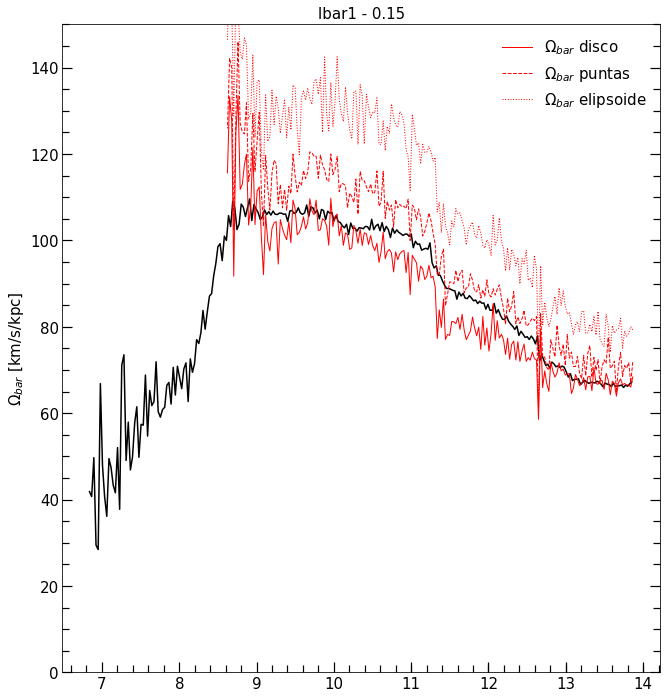

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

ax.plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax.plot(time_M31gd,omega11_M31gd, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax.plot(time_M31gd,omega12_M31gd, color='r', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax.plot(time_M31gd,omega13_M31gd, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
# ax[0,0].plot(time_,omega13_,color='m', lw=1, ls='-', label='$\Omega_{bar}$ elipsoide2')
# ax[0,0].plot(time_,omega33_,color='c', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')

ax.minorticks_on()
ax.tick_params( labelsize=15)
ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax.set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,0].set_xlabel('time [Gyr]',fontsize=15)
ax.set_ylim(0,150)
ax.set_title('lbar1 - 0.15', fontsize=15)
ax.legend(fontsize=15,frameon=False)

Text(0.5,1,'lbar4 - perfiles')

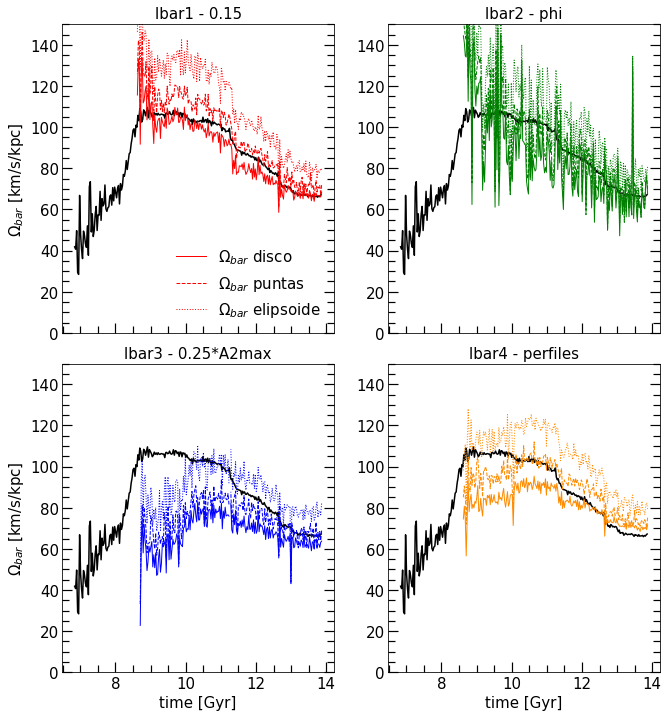

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0,0].plot(time_M31gd,omega11_M31gd, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0,0].plot(time_M31gd,omega12_M31gd, color='r', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,0].plot(time_M31gd,omega13_M31gd, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
# ax[0,0].plot(time_,omega13_,color='m', lw=1, ls='-', label='$\Omega_{bar}$ elipsoide2')
# ax[0,0].plot(time_,omega33_,color='c', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')

ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=15)
ax[0,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,0].set_xlabel('time [Gyr]',fontsize=15)
ax[0,0].set_ylim(0,150)
ax[0,0].set_title('lbar1 - 0.15', fontsize=15)
ax[0,0].legend(fontsize=15,frameon=False)

ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[0,1].plot(time,omega21, color='g', lw=1, label='$\Omega_{bar}$ disco')
# ax[0,1].plot(time,omega22, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[0,1].plot(time,omega23, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].plot(time_M31gd,omega51_M31gd, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[0,1].plot(time_M31gd,omega52_M31gd, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,1].plot(time_M31gd,omega53_M31gd, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
# ax[0,1].plot(time_,omega23_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=15)
ax[0,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[0,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,1].set_xlabel('time [Gyr]',fontsize=15)
ax[0,1].set_ylim(0,150)
ax[0,1].set_title('lbar2 - phi', fontsize=15)
# ax[0,1].legend(fontsize=15,frameon=False)

ax[1,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1,0].plot(time_M31gd,omega31_M31gd, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[1,0].plot(time_M31gd,omega32_M31gd, color='b', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,0].plot(time_M31gd,omega33_M31gd, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
# ax[1,0].plot(time_,omega33_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide2')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=15)
ax[1,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[1,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,0].set_xlabel('time [Gyr]',fontsize=15)
ax[1,0].set_ylim(0,150)
ax[1,0].set_title('lbar3 - 0.25*A2max', fontsize=15)
# ax[1,0].legend(fontsize=15,frameon=False)

ax[1,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[1,1].plot(time,omega41, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
# ax[1,1].plot(time,omega42, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[1,1].plot(time,omega43, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].plot(time_M31gd,omega41_M31gd, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1,1].plot(time_M31gd,omega42_M31gd, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,1].plot(time_M31gd,omega43_M31gd, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
# ax[1,1].plot(time_,omega43_,color='m', lw=1, ls='-',label='$\Omega_{bar}$ elipsoide')
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=15)
ax[1,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,1].set_xlabel('time [Gyr]',fontsize=15)
ax[1,1].set_ylim(0,150)
ax[1,1].set_title('lbar4 - perfiles', fontsize=15)
# ax[1,1].legend(fontsize=15,frameon=False)

## Omega bar vs time GASOLINE  

In [31]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as tiempo
import barstrength2 as strng
import bines2 as bine
import scipy.interpolate as sint
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator
import elipsoide2 as elip

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

# path = '/mnt/sersic2/omarioni/'
path = '/home/ornela/SimCLUES/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
# snapshot = snapshot[::-1]

# path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
path2 = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'

k=0
for j in range(len(snapshot)-1,32,-1):

    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

#     halos =(1,2)#4)
    i = 2
#     for i in halos:
    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    pgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Coordinates'][()]
    mgas = snap['subhalo_00'+str('%s'%i)+'/Gas/Masses'][()]

    pdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Coordinates'][()]
    mdrk = snap['subhalo_00'+str('%s'%i)+'/Drk/Masses'][()]

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = (pgas[:,0]-cm[0])
    ygas = (pgas[:,1]-cm[1])
    zgas = (pgas[:,2]-cm[2])
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = (pdrk[:,0]-cm[0])
    ydrk = (pdrk[:,1]-cm[1])
    zdrk = (pdrk[:,2]-cm[2])
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
#----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(rstr<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(rstr[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(rstr[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-----------------------------------------------------------------------

#componentes de la velocidad del centro de masa
    veloc, = np.where(rstr < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

#-----------------------------------------------------------------------------------

#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
    rtot = np.concatenate([rstr, rgas, rdrk])
    mtot = np.concatenate([mstr, mgas, mdrk])

    limit_tot   = np.where(rtot<r200)
    rtot_sort   = np.sort(rtot[limit_tot])
    rtot_indice = np.argsort(rtot[limit_tot])

    Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

    Vtot = np.sqrt(G*Mc_tot/rtot_sort)

    """CAMBIAR LOS LBAR!!!!!!"""
    lbar1 = lbar1_M31gs[k]
#     lbar2 = lbar2_M31gs[k]
    lbar3 = lbar3_M31gs[k]
    lbar4 = lbar4_M31gs[k]
    lbar5 = lbar5_M31gs[k]
#     lbar6 = lbar6_M31gs[k]
    
    k = k+1
    #-----------------------------------------------------------------------
    #-----OMEGA BAR---------------------------------------------------------
    #-----------------------------------------------------------------------
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    #-----Omega_bar 1---------------------------------------------------------

    mask_supreme, = np.where((Rn<3.*aexp) & (zn<1.*aexp) & (zn>-1.*aexp))

    nbin=20
    med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

    omega_mean   = np.zeros(nbin)

    for ii in range(0,nbin):
        mask, = np.where((Rn[mask_supreme] > nodos[ii]) & (Rn[mask_supreme] < nodos[ii+1]))

        omega_mean[ii] = np.mean(omega[mask_supreme][mask])

    finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")
    
#     if lbar2_M31gd[k] == np.nan:
#         omegabar21 = np.nan
#     else:
#         omegabar21 = finterp1(lbar2_M31gd[k])
        
    omegabar11 = finterp1(lbar1)
#     omegabar21 = finterp1(lbar2)
    if np.isnan(lbar3) == True:
        omegabar31 = np.nan
    else:
        omegabar31 = finterp1(lbar3)
    
    omegabar41 = finterp1(lbar4)
    omegabar51 = finterp1(lbar5)
#     omegabar61 = finterp1(lbar6)

    #-----Omega_bar 2---------------------------------------------------------
    corte, = np.where(rstr < 6.*aexp)
    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)


    tita = np.arctan2(yn,xn)
    find, = np.where(tita<0)
    tita[find] = tita[find]+2*np.pi

    delta_pos = phimed+0.087 #0.087 son mas o menos 5grados
    delta_neg = phimed-0.087

    threshold = 0.15
    mask_s1a, = np.where((Rn<threshold+lbar1)  & (Rn>-threshold+lbar1) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s1b, = np.where((Rn<threshold+lbar1)  & (Rn>-threshold+lbar1) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))

#     mask_s2a, = np.where((Rn<threshold+lbar2)  & (Rn>-threshold+lbar2) & (zn<1.*aexp) & (zn>-1.*aexp) & 
#                              (tita>delta_neg) & (tita<delta_pos))
#     mask_s2b, = np.where((Rn<threshold+lbar2)  & (Rn>-threshold+lbar2) & (zn<1.*aexp) & (zn>-1.*aexp) & 
#                              (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
    
    if np.isnan(lbar3) == True:
        omegabar32 = np.nan
    else:
        mask_s3a, = np.where((Rn<threshold+lbar3)  & (Rn>-threshold+lbar3) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                                 (tita>delta_neg) & (tita<delta_pos))
        mask_s3b, = np.where((Rn<threshold+lbar3)  & (Rn>-threshold+lbar3) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                                 (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
        
        omegabar32 = np.mean(np.concatenate([omega[mask_s3a],omega[mask_s3b]]))

    mask_s4a, = np.where((Rn<threshold+lbar4)  & (Rn>-threshold+lbar4) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s4b, = np.where((Rn<threshold+lbar4)  & (Rn>-threshold+lbar4) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
    
    mask_s5a, = np.where((Rn<threshold+lbar5)  & (Rn>-threshold+lbar5) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg) & (tita<delta_pos))
    mask_s5b, = np.where((Rn<threshold+lbar5)  & (Rn>-threshold+lbar5) & (zn<1.*aexp) & (zn>-1.*aexp) & 
                             (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))
    
#     mask_s6a, = np.where((Rn<threshold+lbar6)  & (Rn>-threshold+lbar6) & (zn<1.*aexp) & (zn>-1.*aexp) & 
#                              (tita>delta_neg) & (tita<delta_pos))
#     mask_s6b, = np.where((Rn<threshold+lbar6)  & (Rn>-threshold+lbar6) & (zn<1.*aexp) & (zn>-1.*aexp) & 
#                              (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))


    omegabar12 = np.mean(np.concatenate([omega[mask_s1a],omega[mask_s1b]]))
#     omegabar22 = np.mean(np.concatenate([omega[mask_s2a],omega[mask_s2b]]))
    
    omegabar42 = np.mean(np.concatenate([omega[mask_s4a],omega[mask_s4b]]))
    omegabar52 = np.mean(np.concatenate([omega[mask_s5a],omega[mask_s5b]]))
#     omegabar62 = np.mean(np.concatenate([omega[mask_s6a],omega[mask_s6b]]))

    #-----Omega_bar 3---------------------------------------------------------

    omegabar13 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1,nbin=50)
#     omegabar23 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2,nbin=50)

    if np.isnan(lbar3) == True:
        omegabar33 = np.nan
    else:
        omegabar33 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=50)
#     omegabar33 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3,nbin=50)
    omegabar43 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4,nbin=50)
    omegabar53 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar5,nbin=50)
#     omegabar63 = elip.elipsoide_(xn,yn,zn,vxn,vyn,vzn,mstr,lbar6,nbin=50)
    
    
#----------------------------------------------------------------------
#---- Rcorot -----------------------------------------------------------
#-----------------------------------------------------------------------

    omega_circ= Vtot/rtot_sort

    interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
    
    if np.isnan(omegabar31) == True:
        rcorot31 = np.nan
    else:
        rcorot31 = interp(omegabar31)
    
    rcorot11 = interp(omegabar11)
#     rcorot21 = interp(omegabar21)
#     rcorot31 = interp(omegabar31)
    rcorot41 = interp(omegabar41)
    rcorot51 = interp(omegabar51)
#     rcorot61 = interp(omegabar61)

#     print 'Rcorot11 = ', rcorot11
#     print 'Rcorot21 = ', rcorot21
#     print 'Rcorot31 = ', rcorot31
#     print 'Rcorot41 = ', rcorot41

    if np.isnan(omegabar32) == True:
        rcorot32 = np.nan
    else:
        rcorot32 = interp(omegabar32)
        
    rcorot12 = interp(omegabar12)
#     rcorot22 = interp(omegabar22)
#     rcorot32 = interp(omegabar32)
    rcorot42 = interp(omegabar42)
    rcorot52 = interp(omegabar52)
#     rcorot62 = interp(omegabar62)

#     print 'Rcorot12 = ', rcorot12
#     print 'Rcorot22 = ', rcorot22
#     print 'Rcorot32 = ', rcorot32
#     print 'Rcorot42 = ', rcorot42

    if np.isnan(omegabar33) == True:
        rcorot33 = np.nan
    else:
        rcorot33 = interp(omegabar33)
        
    rcorot13 = interp(omegabar13)
#     rcorot23 = interp(omegabar23)
#     rcorot33 = interp(omegabar33)
    rcorot43 = interp(omegabar43)
    rcorot53 = interp(omegabar53)
#     rcorot63 = interp(omegabar63)

#     print 'Rcorot13 = ', rcorot13
#     print 'Rcorot23 = ', rcorot23
#     print 'Rcorot33 = ', rcorot33
#     print 'Rcorot43 = ', rcorot43

    archivo = open(path2 + 'omega_time_GS_new_'+str('%03d'%i)+'.dat','a')
    archivo.write(str('%12.8f'% time) +'\t'+
                str('%12.8f'% omegabar11) +'\t'+
#                 str('%12.8f'% omegabar21) +'\t'+
                str('%12.8f'% omegabar31) +'\t'+
                str('%12.8f'% omegabar41) +'\t'+
                str('%12.8f'% omegabar51) +'\t'+
#                 str('%12.8f'% omegabar61) +'\t'+
                str('%12.8f'% omegabar12) +'\t'+
#                 str('%12.8f'% omegabar22) +'\t'+
                str('%12.8f'% omegabar32) +'\t'+
                str('%12.8f'% omegabar42) +'\t'+
                str('%12.8f'% omegabar52) +'\t'+
#                 str('%12.8f'% omegabar62) +'\t'+
                str('%12.8f'% omegabar13) +'\t'+
#                 str('%12.8f'% omegabar23) +'\t'+
                str('%12.8f'% omegabar33) +'\t'+
                str('%12.8f'% omegabar43) +'\t'+    
                str('%12.8f'% omegabar53) +'\n')
#                 str('%12.8f'% omegabar63) +'\n')
    archivo.close()
    
    archivo2 = open(path2 + 'rcorot_time_GS_new_'+str('%03d'%i)+'.dat','a')
    archivo2.write( str('%12.8f'% time) +'\t'+
                   str('%12.8f'% rcorot11) +'\t'+
#                    str('%12.8f'% rcorot21) +'\t'+
                   str('%12.8f'% rcorot31) +'\t'+
                   str('%12.8f'% rcorot41) +'\t'+
                   str('%12.8f'% rcorot51) +'\t'+
#                    str('%12.8f'% rcorot61) +'\t'+
                   str('%12.8f'% rcorot12) +'\t'+
#                    str('%12.8f'% rcorot22) +'\t'+
                   str('%12.8f'% rcorot32) +'\t'+
                   str('%12.8f'% rcorot42) +'\t'+
                   str('%12.8f'% rcorot52) +'\t'+
#                    str('%12.8f'% rcorot62) +'\t'+
                   str('%12.8f'% rcorot13) +'\t'+
#                    str('%12.8f'% rcorot23) +'\t'+
                   str('%12.8f'% rcorot33) +'\t'+
                   str('%12.8f'% rcorot43) +'\t'+
                   str('%12.8f'% rcorot53) +'\n')
#                    str('%12.8f'% rcorot63) +'\n')
    archivo2.close()
    

/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in divide
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:250: RuntimeWarning: divide by zero encountered in divide
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in sqrt
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in divide
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in divide
/home/ornela/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: 

IndexError: index 20 is out of bounds for axis 0 with size 20

In [19]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'

GASOLINE1 = np.loadtxt(path+'omega_time_GS_new_001.dat')
time_M31gs    = GASOLINE1[:,0]
omega11_M31gs = GASOLINE1[:,1]
omega31_M31gs = GASOLINE1[:,2]
omega41_M31gs = GASOLINE1[:,3]
omega51_M31gs = GASOLINE1[:,4]

omega12_M31gs = GASOLINE1[:,5]
omega32_M31gs = GASOLINE1[:,6]
omega42_M31gs = GASOLINE1[:,7]
omega52_M31gs = GASOLINE1[:,8]

omega13_M31gs = GASOLINE1[:,9]
omega33_M31gs = GASOLINE1[:,10]
omega43_M31gs = GASOLINE1[:,11]
omega53_M31gs = GASOLINE1[:,12]

Text(0.5,1,'lbar4 - perfiles')

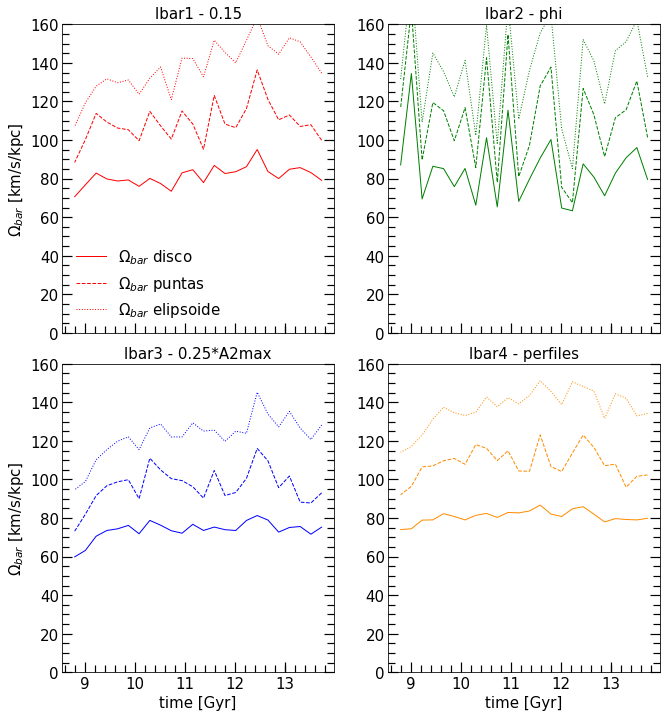

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

# ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0,0].plot(time_M31gs,omega11_M31gs, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0,0].plot(time_M31gs,omega12_M31gs, color='r', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,0].plot(time_M31gs,omega13_M31gs, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=15)
ax[0,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,0].set_xlabel('time [Gyr]',fontsize=15)
ax[0,0].set_ylim(0,160)
ax[0,0].set_title('lbar1 - 0.15', fontsize=15)
ax[0,0].legend(fontsize=15,frameon=False)

# ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[0,1].plot(time,omega21, color='g', lw=1, label='$\Omega_{bar}$ disco')
# ax[0,1].plot(time,omega22, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[0,1].plot(time,omega23, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].plot(time_M31gs,omega51_M31gs, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[0,1].plot(time_M31gs,omega52_M31gs, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,1].plot(time_M31gs,omega53_M31gs, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=15)
ax[0,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[0,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,1].set_xlabel('time [Gyr]',fontsize=15)
ax[0,1].set_ylim(0,160)
ax[0,1].set_title('lbar2 - phi', fontsize=15)
# ax[0,1].legend(fontsize=15,frameon=False)

# ax[1,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1,0].plot(time_M31gs,omega31_M31gs, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[1,0].plot(time_M31gs,omega32_M31gs, color='b', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,0].plot(time_M31gs,omega33_M31gs, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=15)
ax[1,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[1,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,0].set_xlabel('time [Gyr]',fontsize=15)
ax[1,0].set_ylim(0,160)
ax[1,0].set_title('lbar3 - 0.25*A2max', fontsize=15)
# ax[1,0].legend(fontsize=15,frameon=False)

# ax[1,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[1,1].plot(time,omega41, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
# ax[1,1].plot(time,omega42, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[1,1].plot(time,omega43, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].plot(time_M31gs,omega41_M31gs, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1,1].plot(time_M31gs,omega42_M31gs, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,1].plot(time_M31gs,omega43_M31gs, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=15)
ax[1,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,1].set_xlabel('time [Gyr]',fontsize=15)
ax[1,1].set_ylim(0,160)
ax[1,1].set_title('lbar4 - perfiles', fontsize=15)
# ax[1,1].legend(fontsize=15,frameon=False)

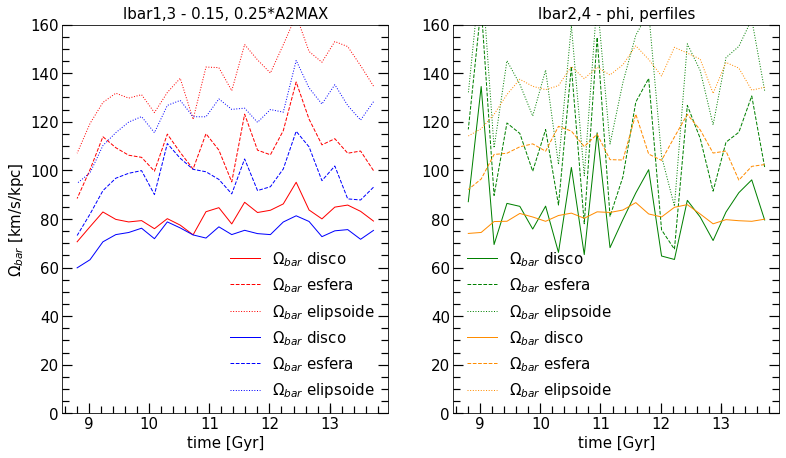

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

# ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0].plot(time_M31gs,omega11_M31gs, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0].plot(time_M31gs,omega12_M31gs, color='r', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0].plot(time_M31gs,omega13_M31gs, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
ax[0].plot(time_M31gs,omega31_M31gs, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[0].plot(time_M31gs,omega32_M31gs, color='b', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0].plot(time_M31gs,omega33_M31gs, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[0].set_xlabel('time [Gyr]',fontsize=15)
ax[0].set_ylim(0,160)
ax[0].set_title('lbar1,3 - 0.15, 0.25*A2MAX', fontsize=15)
ax[0].legend(fontsize=15,frameon=False)

# ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1].plot(time_M31gs,omega51_M31gs, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[1].plot(time_M31gs,omega52_M31gs, color='g', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1].plot(time_M31gs,omega53_M31gs, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1].plot(time_M31gs,omega41_M31gs, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1].plot(time_M31gs,omega42_M31gs, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1].plot(time_M31gs,omega43_M31gs, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1].set_xlabel('time [Gyr]',fontsize=15)
ax[1].set_ylim(0,160)
ax[1].set_title('lbar2,4 - phi, perfiles', fontsize=15)
ax[1].legend(fontsize=15,frameon=False)

plt.show()

In [20]:
path = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/correcciones/'

GASOLINE1 = np.loadtxt(path+'omega_time_GS_new_002.dat')
time_MWgs    = GASOLINE1[:,0]
omega11_MWgs = GASOLINE1[:,1]
omega31_MWgs = GASOLINE1[:,2]
omega41_MWgs = GASOLINE1[:,3]
omega51_MWgs = GASOLINE1[:,4]

omega12_MWgs = GASOLINE1[:,5]
omega32_MWgs = GASOLINE1[:,6]
omega42_MWgs = GASOLINE1[:,7]
omega52_MWgs = GASOLINE1[:,8]

omega13_MWgs = GASOLINE1[:,9]
omega33_MWgs = GASOLINE1[:,10]
omega43_MWgs = GASOLINE1[:,11]
omega53_MWgs = GASOLINE1[:,12]

Text(0.5,1,'lbar4 - perfiles')

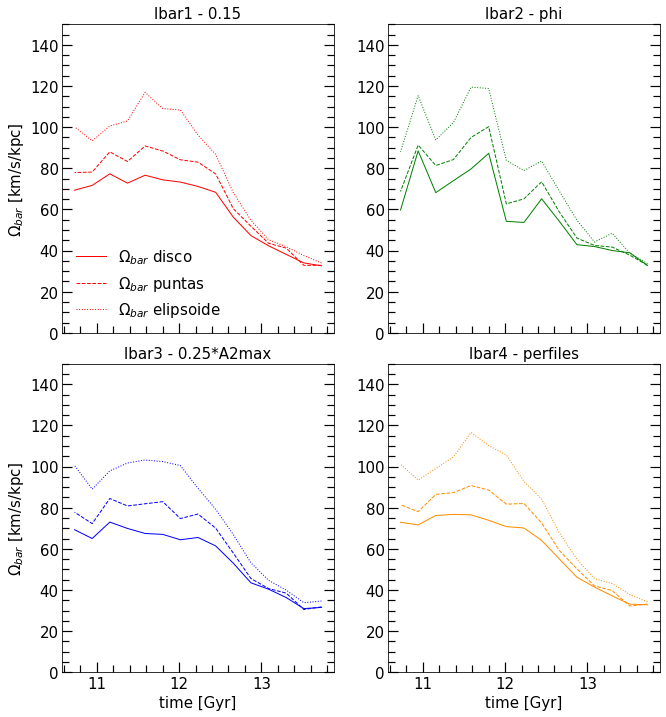

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

# ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0,0].plot(time_MWgs,omega11_MWgs, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0,0].plot(time_MWgs,omega12_MWgs, color='r', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,0].plot(time_MWgs,omega13_MWgs, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=15)
ax[0,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,0].set_xlabel('time [Gyr]',fontsize=15)
ax[0,0].set_ylim(0,150)
ax[0,0].set_title('lbar1 - 0.15', fontsize=15)
ax[0,0].legend(fontsize=15,frameon=False)

# ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[0,1].plot(time,omega21, color='g', lw=1, label='$\Omega_{bar}$ disco')
# ax[0,1].plot(time,omega22, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[0,1].plot(time,omega23, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].plot(time_MWgs,omega51_MWgs, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[0,1].plot(time_MWgs,omega52_MWgs, color='g', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[0,1].plot(time_MWgs,omega53_MWgs, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=15)
ax[0,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[0,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
# ax[0,1].set_xlabel('time [Gyr]',fontsize=15)
ax[0,1].set_ylim(0,150)
ax[0,1].set_title('lbar2 - phi', fontsize=15)
# ax[0,1].legend(fontsize=15,frameon=False)

# ax[1,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1,0].plot(time_MWgs,omega31_MWgs, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[1,0].plot(time_MWgs,omega32_MWgs, color='b', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,0].plot(time_MWgs,omega33_MWgs, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=15)
ax[1,0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[1,0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,0].set_xlabel('time [Gyr]',fontsize=15)
ax[1,0].set_ylim(0,150)
ax[1,0].set_title('lbar3 - 0.25*A2max', fontsize=15)
# ax[1,0].legend(fontsize=15,frameon=False)

# ax[1,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
# ax[1,1].plot(time,omega41, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
# ax[1,1].plot(time,omega42, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
# ax[1,1].plot(time,omega43, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].plot(time_MWgs,omega41_MWgs, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1,1].plot(time_MWgs,omega42_MWgs, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ puntas')
ax[1,1].plot(time_MWgs,omega43_MWgs, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=15)
ax[1,1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1,1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1,1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1,1].set_xlabel('time [Gyr]',fontsize=15)
ax[1,1].set_ylim(0,150)
ax[1,1].set_title('lbar4 - perfiles', fontsize=15)
# ax[1,1].legend(fontsize=15,frameon=False)

In [21]:
Obar_M31gd = np.zeros(len(time_M31gd))
Omin_M31gd = np.zeros(len(time_M31gd))
Omax_M31gd = np.zeros(len(time_M31gd))

for i in range(len(time_M31gd)):
    if ~np.isnan(lbar3_M31gd[i]):
        Obar_M31gd[i] = (omega12_M31gd[i] + omega32_M31gd[i] + omega42_M31gd[i] + omega52_M31gd[i]) / 4
        Omin_M31gd[i] = min(omega12_M31gd[i],omega32_M31gd[i],omega42_M31gd[i],omega52_M31gd[i])
        Omax_M31gd[i] = max(omega12_M31gd[i],omega32_M31gd[i],omega42_M31gd[i],omega52_M31gd[i])
    else: 
        Obar_M31gd[i] = (omega12_M31gd[i] + omega42_M31gd[i] + omega52_M31gd[i]) / 3
        Omin_M31gd[i] = min(omega12_M31gd[i],omega42_M31gd[i],omega52_M31gd[i])
        Omax_M31gd[i] = max(omega12_M31gd[i],omega42_M31gd[i],omega52_M31gd[i])

In [22]:
Obar_M31gs = np.zeros(len(time_M31gs))
Omin_M31gs = np.zeros(len(time_M31gs))
Omax_M31gs = np.zeros(len(time_M31gs))

for i in range(len(time_M31gs)):
    if ~np.isnan(lbar3_M31gs[i]):
        Obar_M31gs[i] = (omega12_M31gs[i] + omega32_M31gs[i] + omega42_M31gs[i] + omega52_M31gs[i]) / 4
        Omin_M31gs[i] = min(omega12_M31gs[i],omega32_M31gs[i],omega42_M31gs[i],omega52_M31gs[i])
        Omax_M31gs[i] = max(omega12_M31gs[i],omega32_M31gs[i],omega42_M31gs[i],omega52_M31gs[i])
    else: 
        Obar_M31gs[i] = (omega12_M31gs[i] + omega42_M31gs[i] + omega52_M31gs[i]) / 3
        Omin_M31gs[i] = min(omega12_M31gs[i],omega42_M31gs[i],omega52_M31gs[i])
        Omax_M31gs[i] = max(omega12_M31gs[i],omega42_M31gs[i],omega52_M31gs[i])

In [23]:
Obar_MWgs = np.zeros(len(time_MWgs))
Omin_MWgs = np.zeros(len(time_MWgs))
Omax_MWgs = np.zeros(len(time_MWgs))

for i in range(len(time_MWgs)):
    if ~np.isnan(lbar3_MWgs[i]):
        Obar_MWgs[i] = (omega12_MWgs[i] + omega32_MWgs[i] + omega42_MWgs[i] + omega52_MWgs[i]) / 4
        Omin_MWgs[i] = min(omega12_MWgs[i],omega32_MWgs[i],omega42_MWgs[i],omega52_MWgs[i])
        Omax_MWgs[i] = max(omega12_MWgs[i],omega32_MWgs[i],omega42_MWgs[i],omega52_MWgs[i])
    else: 
        Obar_MWgs[i] = (omega12_MWgs[i] + omega42_MWgs[i] + omega52_MWgs[i]) / 3
        Omin_MWgs[i] = min(omega12_MWgs[i],omega42_MWgs[i],omega52_MWgs[i])
        Omax_MWgs[i] = max(omega12_MWgs[i],omega42_MWgs[i],omega52_MWgs[i])

In [28]:
print(Obar_M31gd[0], Obar_M31gs[0], Obar_MWgs[0])

(71.4347400675, 99.1619968425, 32.665636060000004)


In [24]:
import pandas as pd
df1 = pd.DataFrame(
    {
        'time_M31gd': time_M31gd[::-1],
        'Obar_M31gd': Obar_M31gd[::-1], 
        'Omin_M31gd': Omin_M31gd[::-1], 
        'Omax_M31gd': Omax_M31gd[::-1],
    }
)
df2 = pd.DataFrame(
    {
        'time_M31gs': time_M31gs[::-1], 
        'Obar_M31gs': Obar_M31gs[::-1], 
        'Omin_M31gs': Omin_M31gs[::-1], 
        'Omax_M31gs': Omax_M31gs[::-1],
    }
)
df3 = pd.DataFrame(
    {
        'time_MWgs': time_MWgs[::-1],
        'Obar_MWgs': Obar_MWgs[::-1],
        'Omin_MWgs': Omin_MWgs[::-1],
        'Omax_MWgs': Omax_MWgs[::-1],
    }
)

In [25]:
prueba1=df1.rolling(10, win_type='boxcar').mean()
prueba2=df2.rolling(3, win_type='boxcar').mean()
prueba3=df3.rolling(3, win_type='boxcar').mean()

In [4]:
# import pandas as pd
# df1 = pd.DataFrame({'omega12_M31gd': omega12_M31gd[::-1]})
# df2 = pd.DataFrame({'omega62_M31gd': omega62_M31gd[::-1]})
# df3 = pd.DataFrame({'omega12_M31gs': omega12_M31gs[::-1]})
# df4 = pd.DataFrame({'omega62_M31gs': omega62_M31gs[::-1]})
# df5 = pd.DataFrame({'omega12_MWgs': omega12_MWgs[::-1]})
# df6 = pd.DataFrame({'omega62_MWgs': omega62_MWgs[::-1]})

In [5]:
# prueba1=df1.rolling(10, win_type='boxcar').mean()
# prueba2=df2.rolling(10, win_type='boxcar').mean()
# prueba3=df3.rolling(2, win_type='boxcar').mean()
# prueba4=df4.rolling(2, win_type='boxcar').mean()
# prueba5=df5.rolling(2, win_type='boxcar').mean()
# prueba6=df6.rolling(2, win_type='boxcar').mean()

[ 8.16823908  8.84929622  9.61688098 10.48459376 11.46854229 12.58803176
 13.86663323]


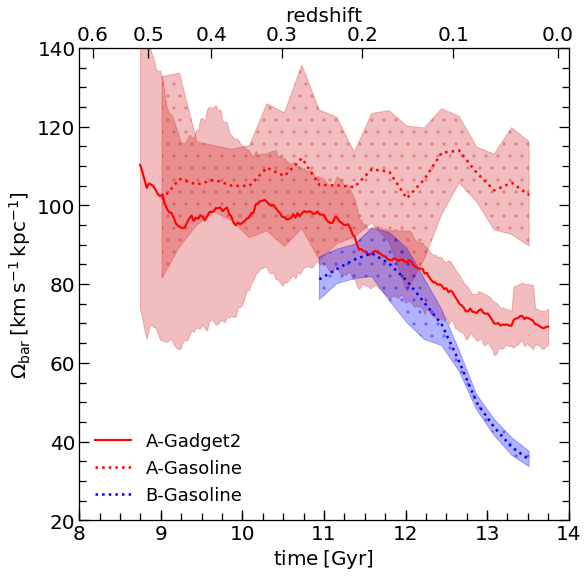

In [49]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))#,sharex=True, sharey=True)
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.10, left =0.12, right = 0.97, top = 0.92)

ax.plot(
    prueba1['time_M31gd'][prueba1['time_M31gd']>8.685],
    prueba1['Obar_M31gd'][prueba1['time_M31gd']>8.685],
    ls='-',
    lw=2.1,
    color='r',
    label='A-Gadget2',
)
ax.plot( 
    prueba2['time_M31gs'][prueba2['time_M31gs']>8.087],
    prueba2['Obar_M31gs'][prueba2['time_M31gs']>8.087],
    ls=':',
    lw=2.5,
    color='r',
    label='A-Gasoline', 
    zorder=1,
)
ax.plot(
    prueba3['time_MWgs'][prueba3['time_MWgs']>10.622],
    prueba3['Obar_MWgs'][prueba3['time_MWgs']>10.622],
    ls=':',
    lw=2.5,
    color='b',
    label='B-Gasoline',
)

ax.fill_between(
    prueba1['time_M31gd'][prueba1['time_M31gd']>8.685],
    prueba1['Omin_M31gd'][prueba1['time_M31gd']>8.685],
    prueba1['Omax_M31gd'][prueba1['time_M31gd']>8.685],
    color='tab:red',
    alpha=0.3,
)
ax.fill_between(
    prueba2['time_M31gs'][prueba2['time_M31gs']>8.087],
    prueba2['Omin_M31gs'][prueba2['time_M31gs']>8.087],
    prueba2['Omax_M31gs'][prueba2['time_M31gs']>8.087],
    color='tab:red',
    alpha=0.3,
    hatch='.',
)
ax.fill_between(
    prueba3['time_MWgs'][prueba3['time_MWgs']>10.622],
    prueba3['Omin_MWgs'][prueba3['time_MWgs']>10.622], 
    prueba3['Omax_MWgs'][prueba3['time_MWgs']>10.622],
    color='b',
    alpha=0.3, 
    hatch='.', 
    zorder=1,
)

ax.set_xticks([8,9,10,11,12,13,14])
ax.set_xlim(8,14)
ax.set_ylim(20,140)
ax.set_xlabel('$\mathrm{time\:[Gyr]}$', fontsize=20)
ax.set_ylabel('$\mathrm{\Omega_{bar}\:[km\:s^{-1}\:kpc^{-1}]}$', fontsize=20)
ax.minorticks_on()

ax.spines['right'].set_linewidth(1.3)
ax.spines['left'].set_linewidth(1.3)
ax.spines['top'].set_linewidth(1.3)
ax.spines['bottom'].set_linewidth(1.3)

ax.tick_params( labelsize=20)
ax.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=False)
ax.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=False)
ax.xaxis.set_minor_locator(MultipleLocator(1/4.)) 
ax.legend(fontsize=18,frameon=False, loc=3)

ax2 = ax.twiny()
new_tick_label = np.array([0.6,0.5,0.4,0.3,0.2,0.1,0])
ticks_pos = tiempo.conv(new_tick_label, h, omega_lambda, omega_matter)
print ticks_pos
ax2.set_xticks(ticks_pos)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels(new_tick_label)
ax2.set_xlabel('redshift',fontsize=20)
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=7, width=1.3,which='minor', direction='in', right=True,top=True)
ax2.tick_params('both', length=10, width=1.3,which='major', direction='in', right=True,top=True)

# path = '/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
path = '/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_imagenes/correcciones/'
fig.savefig(path + 'omega_time_new.pdf', dpi = 100, xxbox_inches='tight')
plt.show()

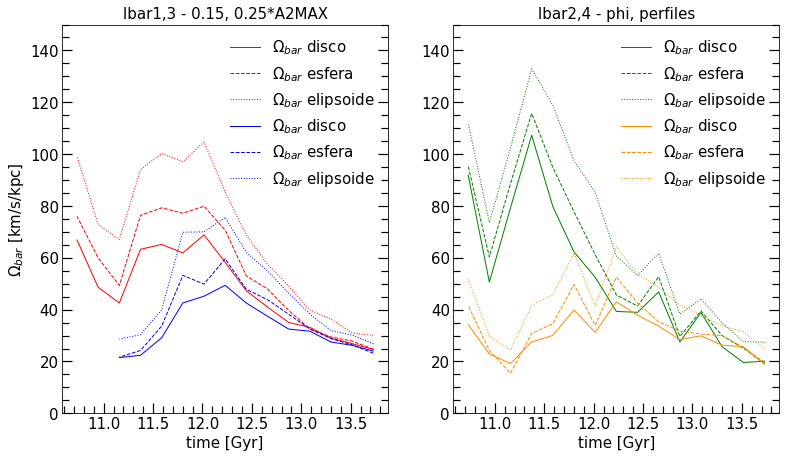

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True)
#                        gridspec_kw = {'height_ratios':[2,5]})
fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0.2, hspace= 0.1)

# ax[0,0].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[0].plot(time,omega11, color='r', lw=1, label='$\Omega_{bar}$ disco')
ax[0].plot(time,omega12, color='r', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0].plot(time,omega13, color='r', lw=1, ls=':', label='$\Omega_{bar}$ elipsoide')
ax[0].plot(time,omega31, color='b', lw=1, label='$\Omega_{bar}$ disco')
ax[0].plot(time,omega32, color='b', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[0].plot(time,omega33, color='b', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[0].minorticks_on()
ax[0].tick_params( labelsize=15)
ax[0].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[0].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
ax[0].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[0].set_xlabel('time [Gyr]',fontsize=15)
ax[0].set_ylim(0,150)
ax[0].set_title('lbar1,3 - 0.15, 0.25*A2MAX', fontsize=15)
ax[0].legend(fontsize=15,frameon=False)

# ax[0,1].plot(tt, veloc_ang*2*np.pi/360.*1.0219051207939474,'k')
ax[1].plot(time,omega51, color='g', lw=1, label='$\Omega_{bar}$ disco')
ax[1].plot(time,omega52, color='g', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1].plot(time,omega53, color='g', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1].plot(time,omega61, color='darkorange', lw=1, label='$\Omega_{bar}$ disco')
ax[1].plot(time,omega62, color='darkorange', lw=1, ls='--', label='$\Omega_{bar}$ esfera')
ax[1].plot(time,omega63, color='darkorange', lw=1, ls=':',label='$\Omega_{bar}$ elipsoide')
ax[1].minorticks_on()
ax[1].tick_params( labelsize=15)
ax[1].tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
ax[1].tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
# ax[1].set_ylabel('$\Omega_{bar}$ [km/s/kpc]',fontsize=15)
ax[1].set_xlabel('time [Gyr]',fontsize=15)
ax[1].set_ylim(0,150)
ax[1].set_title('lbar2,4 - phi, perfiles', fontsize=15)
ax[1].legend(fontsize=15,frameon=False)

plt.show()

### omega bar gadget a z=0

In [68]:
# %%time
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import barstrength2 as strng
import bines2 as bine
# import elipsoide as elip
import scipy.interpolate as sint
import elipsoide2 as elip

#Parámetros cosmológicos
#--------------------------------------------------------------------------
h=0.732
G = 4.299e-6
a0=1.
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
#---------------------------------------------------------------------------

path0 = '/home/omarioni/'
atime = np.loadtxt(path0 + 'redshift_outputs.txt')
aexp = atime[:,2]

path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
# archivo = open(path2 + 'omega_set_GD.dat','a')


path = '/mnt/is2/alejandro/ornella/'
# snapshot=range(496,300,-1)
# for isnap in snapshot:

isnap = 496
snap = h5py.File(path+'outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    
halos = (0,1,3)

# for i in halos:
i = 0
cm   = snap['subhalo_'+ str('%03d' %i) + '/Center'][()]
r200 = snap['subhalo_'+ str('%03d' %i) + '/R200'][()]

pstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Coordinates'][()]
IDs  = snap['subhalo_'+ str('%03d' %i) + '/Str/Ids'][()]
mstr = snap['subhalo_'+ str('%03d' %i) + '/Str/Masses'][()]
vel  = snap['subhalo_'+ str('%03d' %i) + '/Str/Velocities'][()]

pgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Coordinates'][()]
mgas = snap['subhalo_'+ str('%03d' %i) + '/Gas/Masses'][()]

pdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Coordinates'][()]
mdrk = snap['subhalo_'+ str('%03d' %i) + '/Drk/Masses'][()]

z = a0/aexp[isnap] - 1.
Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
# time = tiempo.conv(z, h, omega_lambda, omega_matter)

#---aca paso las coordenadas respecto al centro de la galaxia------
xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

xgas = (pgas[:,0]-cm[0])*aexp[isnap]/h
ygas = (pgas[:,1]-cm[1])*aexp[isnap]/h
zgas = (pgas[:,2]-cm[2])*aexp[isnap]/h
rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

xdrk = (pdrk[:,0]-cm[0])*aexp[isnap]/h
ydrk = (pdrk[:,1]-cm[1])*aexp[isnap]/h
zdrk = (pdrk[:,2]-cm[2])*aexp[isnap]/h
rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
mstr = mstr/h
mgas = mgas/h
mdrk = mdrk/h

r200 = r200*aexp[isnap]/h
rgal = 0.15*r200

limit = np.where(rstr<rgal)
r_sort = np.sort(rstr[limit])
r_indice = np.argsort(rstr[limit])

Mc_str = np.cumsum((mstr[limit])[r_indice])
M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
razon = Mc_str/M_gal
cincuenta, = np.where(razon < 0.5)

r50 = r_sort[cincuenta][-1]              

#------------------masa total en r200 (Mvir)--------------------------         
veloc,=np.where(rstr<r50)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[isnap])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

xn = e1x*xstr + e1y*ystr + e1z*zstr
yn = e2x*xstr + e2y*ystr + e2z*zstr
zn = e3x*xstr + e3y*ystr + e3z*zstr
vxn = e1x*vx + e1y*vy + e1z*vz
vyn = e2x*vx + e2y*vy + e2z*vz
vzn = e3x*vx + e3y*vy + e3z*vz

#------------------------------------------------------------------
rtot = np.concatenate([rstr, rgas, rdrk])
mtot = np.concatenate([mstr, mgas, mdrk])

limit_tot   = np.where(rtot<r200)
rtot_sort   = np.sort(rtot[limit_tot])
rtot_indice = np.argsort(rtot[limit_tot])

Mc_tot = np.cumsum((mtot[limit_tot])[rtot_indice])

Vtot = np.sqrt((G*Mc_tot*1e10)/rtot_sort)


print 'lbar1 = ', lbar1_M31gd[0]
print 'lbar2 = ', lbar2_M31gd[0]
print 'lbar3 = ', lbar3_M31gd[0]
print 'lbar4 = ', lbar4_M31gd[0], '\n'


#-----------------------------------------------------------------------
#-----OMEGA BAR---------------------------------------------------------
#-----------------------------------------------------------------------
Rn = np.sqrt(xn**2 + yn**2)

Vtg = (-yn*vxn + xn*vyn)/Rn

omega = Vtg/Rn

#-----Omega_bar 1---------------------------------------------------------

mask_supreme, = np.where((Rn<3.*aexp[isnap]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]))

nbin=20
med, nodos = bine.rbin1(Rn[mask_supreme],nbin)

omega_mean   = np.zeros(nbin)

for i in range(0,nbin):
    mask, = np.where((Rn[mask_supreme] > nodos[i]) & (Rn[mask_supreme] < nodos[i+1]))

    omega_mean[i] = np.mean(omega[mask_supreme][mask])

finterp1 = sint.interp1d(med,omega_mean,fill_value="extrapolate")

omegabar11 = finterp1(lbar1_M31gd[0])
omegabar21 = finterp1(lbar2_M31gd[0])
omegabar31 = finterp1(lbar3_M31gd[0])
omegabar41 = finterp1(lbar4_M31gd[0])

print 'omega_bar11 = ', omegabar11
print 'omega_bar21 = ', omegabar21
print 'omega_bar31 = ', omegabar31
print 'omega_bar41 = ', omegabar41, '\n'


#-----Omega_bar 2---------------------------------------------------------
corte, = np.where(rstr < 6.*aexp[isnap])
A2max, rmax, phimax = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)


tita = np.arctan2(yn,xn)
find, = np.where(tita<0)
tita[find] = tita[find]+2*np.pi

delta_pos = phimax+0.087 #0.087 son mas o menos 5grados
delta_neg = phimax-0.087

threshold = 0.15
mask_s1a, = np.where((Rn<threshold+lbar1_M31gd[0])  & (Rn>-threshold+lbar1_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg) & (tita<delta_pos))

mask_s1b, = np.where((Rn<threshold+lbar1_M31gd[0])  & (Rn>-threshold+lbar1_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))

mask_s2a, = np.where((Rn<threshold+lbar2_M31gd[0])  & (Rn>-threshold+lbar2_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg) & (tita<delta_pos))

mask_s2b, = np.where((Rn<threshold+lbar2_M31gd[0])  & (Rn>-threshold+lbar2_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))

mask_s3a, = np.where((Rn<threshold+lbar3_M31gd[0])  & (Rn>-threshold+lbar3_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg) & (tita<delta_pos))

mask_s3b, = np.where((Rn<threshold+lbar3_M31gd[0])  & (Rn>-threshold+lbar3_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))

mask_s4a, = np.where((Rn<threshold+lbar4_M31gd[0])  & (Rn>-threshold+lbar4_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg) & (tita<delta_pos))

mask_s4b, = np.where((Rn<threshold+lbar4_M31gd[0])  & (Rn>-threshold+lbar4_M31gd[0]) & (zn<1.*aexp[isnap]) & (zn>-1.*aexp[isnap]) & 
                         (tita>delta_neg+np.pi) & (tita<delta_pos+np.pi))


omegabar12 = np.mean(np.concatenate([omega[mask_s1a],omega[mask_s1b]]))
omegabar22 = np.mean(np.concatenate([omega[mask_s2a],omega[mask_s2b]]))
omegabar32 = np.mean(np.concatenate([omega[mask_s3a],omega[mask_s3b]]))
omegabar42 = np.mean(np.concatenate([omega[mask_s4a],omega[mask_s4b]]))

print 'omega_bar12 = ', omegabar12
print 'omega_bar22 = ', omegabar22
print 'omega_bar32 = ', omegabar32
print 'omega_bar42 = ', omegabar42, '\n'

#-----Omega_bar 3---------------------------------------------------------
# corte2, = np.where(rn<3*aexp[isnap])
# A2max, rmax, phimax = strng.a2max(mstr[corte2], xn[corte2], yn[corte2], 20)

# omegabar13, xn1, yn1, zn1, autovec1, A1, B1, C1 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,lbar1_M31gd[0], phimax)
# omegabar23, xn2, yn2, zn2, autovec2, A2, B2, C2 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,lbar2_M31gd[0], phimax)
# omegabar33, xn3, yn3, zn3, autovec3, A3, B3, C3 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,lbar3_M31gd[0], phimax)
# omegabar43, xn4, yn4, zn4, autovec4, A4, B4, C4 = elip.elipsoide(xn,yn,zn,vxn,vyn,vzn,lbar4_M31gd[0], phimax)


# print 'omega_bar13 = ', omegabar13
# print 'omega_bar23 = ', omegabar23
# print 'omega_bar33 = ', omegabar33
# print 'omega_bar43 = ', omegabar43, '\n'

# print 'V1', autovec1
# print 'V2', autovec2
# print 'V3', autovec3
# print 'V4', autovec4, '\n'

# print 'A1=', A1, 'B1=', B1, 'C1=', C1
# print 'A2=', A2, 'B2=', B2, 'C2=', C2
# print 'A3=', A3, 'B3=', B3, 'C3=', C3
# print 'A4=', A4, 'B4=', B4, 'C4=', C4, '\n'


# omegabar13n, xn1n, yn1n, zn1n, V11, V21, V31, A1, B1, C1 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar1)
# omegabar23n, xn2n, yn2n, zn2n, V12, V22, V32, A2, B2, C2 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar2)
# omegabar33n, xn3n, yn3n, zn3n, V13, V23, V33, A3, B3, C3 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar3)
# omegabar43n, xn4n, yn4n, zn4n, V14, V24, V34, A4, B4, C4 = elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,M31gd_lbar4)

omegabar13 = elip.elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar1_M31gd[0])
omegabar23 = elip.elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar2_M31gd[0])
omegabar33 = elip.elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar3_M31gd[0])
omegabar43 = elip.elipsoide2(xn,yn,zn,vxn,vyn,vzn,mstr,lbar4_M31gd[0])

print 'omega_bar13 = ', omegabar13
print 'omega_bar23 = ', omegabar23
print 'omega_bar33 = ', omegabar33
print 'omega_bar43 = ', omegabar43, '\n'

# print 'V1', V11, V21, V31
# print 'V2', V12, V22, V32
# print 'V3', V13, V23, V33
# print 'V4', V14, V24, V34, '\n'

# print 'A1=', A1, 'B1=', B1, 'C1=', C1
# print 'A2=', A2, 'B2=', B2, 'C2=', C2
# print 'A3=', A3, 'B3=', B3, 'C3=', C3
# print 'A4=', A4, 'B4=', B4, 'C4=', C4, '\n'
#-----------------------------------------------------------------------
#---- Rcorot -----------------------------------------------------------
#-----------------------------------------------------------------------

omega_circ= Vtot/rtot_sort

interp  = sint.interp1d(omega_circ,rtot_sort,fill_value="extrapolate")
rcorot11 = interp(omegabar11)
rcorot21 = interp(omegabar21)
rcorot31 = interp(omegabar31)
rcorot41 = interp(omegabar41)

print 'Rcorot11 = ', rcorot11
print 'Rcorot21 = ', rcorot21
print 'Rcorot31 = ', rcorot31
print 'Rcorot41 = ', rcorot41, '\n'


rcorot12 = interp(omegabar12)
rcorot22 = interp(omegabar22)
rcorot32 = interp(omegabar32)
rcorot42 = interp(omegabar42)

print 'Rcorot12 = ', rcorot12
print 'Rcorot22 = ', rcorot22
print 'Rcorot32 = ', rcorot32
print 'Rcorot42 = ', rcorot42, '\n'


rcorot13 = interp(omegabar13)
rcorot23 = interp(omegabar23)
rcorot33 = interp(omegabar33)
rcorot43 = interp(omegabar43)

print 'Rcorot13 = ', rcorot13
print 'Rcorot23 = ', rcorot23
print 'Rcorot33 = ', rcorot33
print 'Rcorot43 = ', rcorot43, '\n'


lbar1 =  1.39687181
lbar2 =  1.93518513
lbar3 =  1.53419664
lbar4 =  2.30243405 

omega_bar11 =  68.3845701057782
omega_bar21 =  52.143157623213774
omega_bar31 =  63.77847147554848
omega_bar41 =  43.58592667664339 

omega_bar12 =  71.826004
omega_bar22 =  55.477203
omega_bar32 =  68.81102
omega_bar42 =  41.090557 

omega_bar13 =  73.69783649221246
omega_bar23 =  64.53071923840999
omega_bar33 =  75.24162086316768
omega_bar43 =  47.525857970477716 

Rcorot11 =  2.209235200321064
Rcorot21 =  2.7767857366456083
Rcorot31 =  2.342399689179057
Rcorot41 =  3.228545095803534 

Rcorot12 =  2.1198404
Rcorot22 =  2.6350431
Rcorot32 =  2.1978424
Rcorot42 =  3.392942 

Rcorot13 =  2.074485108424741
Rcorot23 =  2.3194990618753866
Rcorot33 =  2.0389324206621744
Rcorot43 =  3.0018372561121582 



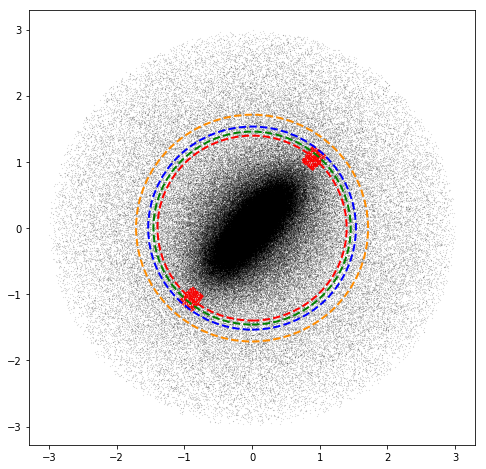

In [65]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(xn[np.where(rstr<3.)],yn[np.where(rstr<3.)],'.k',markersize=0.1)
ax.plot(xn[mask_s1a],yn[mask_s1a],'.r',markersize=0.5)
ax.plot(xn[mask_s1b],yn[mask_s1b],'.r',markersize=0.5)
circ1 = patches.Circle((0., 0.), lbar1_M31gd[0], fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), lbar5_M31gd[0], fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), lbar3_M31gd[0], fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), lbar6_M31gd[0], fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

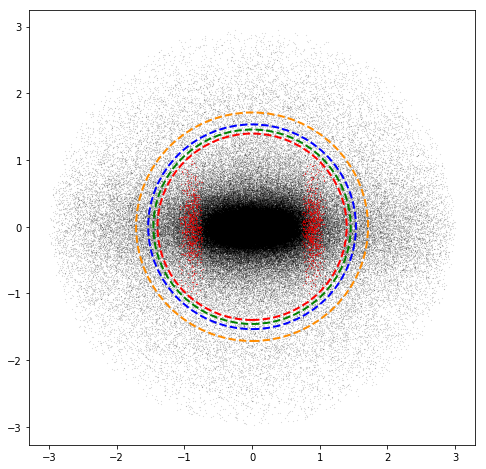

In [66]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(xn[np.where(rstr<3.)],zn[np.where(rstr<3.)],'.k',markersize=0.1)
ax.plot(xn[mask_s1a],zn[mask_s1a],'.r',markersize=0.5)
ax.plot(xn[mask_s1b],zn[mask_s1b],'.r',markersize=0.5)
circ1 = patches.Circle((0., 0.), lbar1_M31gd[0], fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), lbar5_M31gd[0], fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), lbar3_M31gd[0], fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), lbar6_M31gd[0], fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

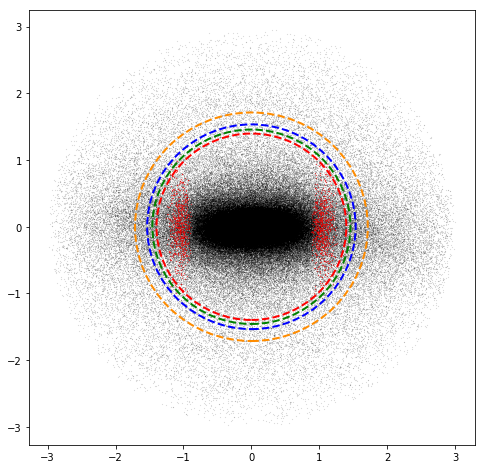

In [67]:
import matplotlib.patches as patches
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), sharex=True)
# fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

ax.plot(yn[np.where(rstr<3.)],zn[np.where(rstr<3.)],'.k',markersize=0.1)
ax.plot(yn[mask_s1a],zn[mask_s1a],'.r',markersize=0.5)
ax.plot(yn[mask_s1b],zn[mask_s1b],'.r',markersize=0.5)
circ1 = patches.Circle((0., 0.), lbar1_M31gd[0], fc='None',ec='r',ls='--',lw=2,zorder=10)
circ2 = patches.Circle((0., 0.), lbar5_M31gd[0], fc='None',ec='g',ls='--',lw=2,zorder=10)
circ3 = patches.Circle((0., 0.), lbar3_M31gd[0], fc='None',ec='b',ls='--',lw=2,zorder=10)
circ4 = patches.Circle((0., 0.), lbar6_M31gd[0], fc='None',ec='darkorange',ls='--',lw=2,zorder=10)
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)

In [47]:
## Calculamos las particulas dentro de un elipsoide de semieje mayor = radio
## el angulo es el phi, es para alinear el semieje mayor con el eje x
from goto import with_goto
import numpy as np
import tenform as ten
import bines2 as bine
import scipy.interpolate as sint
@with_goto
def elipsoide2(x,y,z,vx,vy,vz,m,radio, nbin=20):
    

    if np.isnan(radio)== True:
        omegabar = np.nan
        goto .end
    
    r = np.sqrt(x**2 + y**2 + z**2)

    limit, = np.where(r < radio)
    
    jx = sum(m[limit]*(y[limit]*vz[limit]-z[limit]*vy[limit]))
    jy = sum(m[limit]*(z[limit]*vx[limit]-x[limit]*vz[limit]))
    jz = sum(m[limit]*(x[limit]*vy[limit]-y[limit]*vx[limit]))

    j = np.sqrt(jx**2 + jy**2 + jz**2)
    Jt = np.ndarray(3)
    Jt[0] = jx
    Jt[1] = jy
    Jt[2] = jz
    
    tensor   = ten.tenf(x[limit], y[limit], z[limit]) #calculo el tensor de forma
    matriz   = np.linalg.eig(tensor) #saco los autovalores
    autoval  = matriz[0]
    autovec  = matriz[1]

    asort  = np.argsort(autoval) #los ordeno de menor a mayor

    A = np.sqrt(autoval[asort][2]) #semiejes
    B = np.sqrt(autoval[asort][1])
    C = np.sqrt(autoval[asort][0])
    
    V1 = autovec[:,asort][:,2] 
    V2 = autovec[:,asort][:,1]
    V3 = autovec[:,asort][:,0]
    
    
    modV = np.sqrt(np.dot(V3,V3))
    tita = np.arccos(np.dot(Jt,V3)/(j*modV))
    
    if tita > np.pi/2.:
        V3 = -V3
        
    cruz = np.cross(V3,V1)
    test = np.sign(cruz) == np.sign(V2)
    if test.all() == False:
        V2 = cruz

    aa = radio #normalizo al radio que yo quiero
    bb = (B/A)*radio
    cc = (C/A)*radio
    
    pos = np.ndarray([len(x[limit]),3])
    pos[:,0] = x[limit]
    pos[:,1] = y[limit]
    pos[:,2] = z[limit]
    
    xx = np.zeros(len(x[limit]))
    yy = np.zeros(len(x[limit]))
    zz = np.zeros(len(x[limit]))
    
    xx[:] = np.dot(pos[:],V1)
    yy[:] = np.dot(pos[:],V2)
    zz[:] = np.dot(pos[:],V3)

    Relip = np.sqrt((xx/aa)**2 + (yy/bb)**2 + (zz/cc)**2) # formula del elipsoide
    mask, = np.where(Relip <= 1.)

    xn  = xx[mask]
    yn  = yy[mask]
    zn  = zz[mask]
    
    vel = np.ndarray([len(x[limit]),3])
    vel[:,0] = vx[limit]
    vel[:,1] = vy[limit]
    vel[:,2] = vz[limit]
    
    vxx = np.zeros(len(x[limit]))
    vyy = np.zeros(len(x[limit]))
    vzz = np.zeros(len(x[limit]))
    
    vxx[:] = np.dot(vel[:],V1)
    vyy[:] = np.dot(vel[:],V2)
    vzz[:] = np.dot(vel[:],V3)
    
    vxn = vxx[mask]
    vyn = vyy[mask]
    vzn = vzz[mask]

    rn = np.sqrt(xn**2 + yn**2 + zn**2)
    Rn = np.sqrt(xn**2 + yn**2)

    Vtg = (-yn*vxn + xn*vyn)/Rn

    omega = Vtg/Rn

    med, nodos = bine.rbin1(rn,nbin)
    omega_mean = np.zeros(nbin)

    for i in range(0,nbin):
        inbin, = np.where((rn > nodos[i]) & (rn < nodos[i+1]))

        omega_mean[i] = np.mean(omega[inbin])

    finterp = sint.interp1d(med,omega_mean,fill_value="extrapolate")

    omegabar = finterp(radio)
    
    label .end
    return omegabar #xn, yn, zn, V1, V2, V3, A, B, C